<div class="container">
<div class="jumbotron">
    <h1 style="font-weight: bold; font-size: 2em;">CPSC 425: Computer Vision</h1>      
    <p style="margin-bottom: 1em; font-family: sans-serif; text-align: justify;">
        Assignment 6: Deep Learning
    </p>
    Attribution: This assignment is developed based on the example <a href="https://github.com/pytorch/examples/blob/master/mnist/main.py">here</a>.
</div>
</div>

# Preface

This assignment consists of three parts: In the first part, you will implement various PyTorch deep learning layers using Numpy; in part two, you will experiment with different hyper-parameters on a image classification task and find the best hyper-parameters; lastly, you will investigate a state-of-the-art neural architecture from the PyTorch model zoo.

**IMPORTANT**: Colab allows you to train your network in either a cpu or a **free** gpu. You can request a Colab GPU by clicking on the `Edit-Notebook Settings-HardwareAccelerator` and choose `GPU`. After you chose the GPU, the python program will restart from scratch. If you run the cell below, you will see whether a GPU has been assigned to you. If you cannot get a GPU on time, you can simply use a cpu, which should work for this assignment but slower.

**IMPORTANT**: Before proceeding, it is important to understand what is Google Colab notebooks. You can play around with this short tutorial [here](https://colab.research.google.com/notebooks/intro.ipynb)

In [1]:
!nvidia-smi

Sun Apr 11 19:54:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Implement Neural Network Layers

In this section, you are going to implement some fundamental deep learning layers of PyTorch using numpy arrays. Through this implementation, you will gain better understandings of the deep learning tools we introduced in class, such as activation functions, linear layers, max pooling layers and convolution layers. As we mentioned in class, each deep learning layer has two operators: `forward` and `backward`. In the forward pass, data are piped through a computational graph (each node is a deep learning layer) to obtain the final prediction. When comparing the prediction with a loss, gradients are backpropagated in the inverse direction of the graph, which allows us to compute the gradients with respect to the model parameters and we can follow the negative gradient to update the parameters (a.k.a. learning the parameters).

You will be implementing the `forward` pass of the `ReLU`, `MaxPool2d`, `Linear`, and `Conv2d` layers. Since the `backward` pass is quite intensive, we only require you to implement it for ther `ReLU` layer. Although in practice, most deep learning library (such as PyTorch) would compute the gradients for you automatically using the computational graph, which is called `AutoGrad`, sometimes you do need to implement your custom gradient backward.

Let's kick start by importing the following dependencies:

In [2]:
import torch
import torch.nn as nn
import numpy as np
import hw_utils

## ReLU Activation `[2 marks]`

Implement the ReLU layer by filling in numpy code in between `START` and `END`. The assertions should tell you what we expect your input and output to be (such as the shape and the data type). Note that for ReLU, the input can be in any shape. Your solution should produce a numpy array that is very close to the outputs of a PyTorch implementations, which you can check by looking at the errors from the tests below. DO NOT remove the tests and include the errors in your final version upon submission.

In [4]:
# TODO
class nn_ReLU():
    def __init__(self):
        pass
    def forward(self, X):
        assert isinstance(X, np.ndarray)
        in_shape = X.shape
        # START
        out = X
        isLess0 = out<0
        out[isLess0] = 0.0
        # END
        assert isinstance(out, np.ndarray)
        assert out.shape == X.shape
        return out
    
    def backward(self, X):
        # compute the gradient of y with respect to X
        # where y = ReLU(X)
        grad = np.ones_like(X)
        # START
        grad[X<0] = 0.0
        # END
        return grad

# Note: the following test cases only test for the forward function. 
hw_utils.test_relu(in_shape=[7, 5, 3, 1], Layer=nn_ReLU)
hw_utils.test_relu(in_shape=[100], Layer=nn_ReLU)
hw_utils.test_relu(in_shape=[3, 4, 4], Layer=nn_ReLU)

# More tests for relu forward
X_test = np.array([-3.0, 0.0, 2.0, -1.5])
relu = nn_ReLU()
assert np.linalg.norm(relu.forward(X_test) - np.array([0.0, 0.0, 2.0, 0.0]))<1e-5
# More tests for relu backward
X_test = np.array([-3.0, 0.1, 2.0, -1.5])
assert np.linalg.norm(relu.backward(X_test) - np.array([0.0, 1.0, 1.0, 0.0]))<1e-5

norm(out_np - out_torch) = 0.000000
norm(out_np - out_torch) = 0.000000
norm(out_np - out_torch) = 0.000000


## Maxpooling Layer `[2 marks]`

Implement the 2d pooling layer by filling in numpy code in between `START` and `END`. The assertions should tell you what we expect your input and output to be (such as the shape and the data type). Note that for 2d max pooling, you will work with inputs with shape `(N, C, size, size)` where `N` is the number of examples, `C` is the channel size, and `size` is the width and height of the feature map. The stride of this max pooling would be `size` as well. Your solution should produce a numpy array that is very close to the outputs of a PyTorch implementations, which you can check by looking at the errors from the tests below. DO NOT remove the tests and include the errors in your final version upon submission.

In [5]:
# TODO
class nn_MaxPool2d():
    def __init__(self, kernel_size):
        self.kernel_size = kernel_size
        
    def forward(self, X):
        assert isinstance(X, np.ndarray)
        assert len(X.shape) == 4
        assert X.shape[2] == X.shape[3],\
            'You can assume width and height are the same'
        N, C, size, _ = X.shape
        assert size >= self.kernel_size,\
            'You can assume the feature map is always at least as big as the kernel size'
        kernel_size = self.kernel_size
        
        # START
        out_size = int(np.floor((size - kernel_size) / kernel_size)) + 1
        out = np.zeros((N, C, out_size, out_size))
        # populate the output array per sample, per channel, per neighborhood
        for sample in range(0, N):
          for channel in range(0, C):
            for row in range(0, out_size):
              for col in range(0, out_size):
                neighborhood = X[sample, channel, kernel_size*row:kernel_size*(row+1), kernel_size*col:kernel_size*(col+1)]
                out[sample, channel, row, col] =  np.amax(neighborhood)
        # END
        out = out.reshape(N, C, out_size, out_size)
        return out

hw_utils.test_maxpool(N=3, C=6, size=4, kernel_size=1, Layer=nn_MaxPool2d)
hw_utils.test_maxpool(N=3, C=6, size=4, kernel_size=2, Layer=nn_MaxPool2d)
hw_utils.test_maxpool(N=3, C=6, size=4, kernel_size=4, Layer=nn_MaxPool2d)

hw_utils.test_maxpool(N=3, C=6, size=16, kernel_size=4, Layer=nn_MaxPool2d)
hw_utils.test_maxpool(N=3, C=6, size=16, kernel_size=8, Layer=nn_MaxPool2d)

hw_utils.test_maxpool(N=3, C=6, size=15, kernel_size=4, Layer=nn_MaxPool2d)
hw_utils.test_maxpool(N=3, C=6, size=15, kernel_size=8, Layer=nn_MaxPool2d)

hw_utils.test_maxpool(N=3, C=6, size=13, kernel_size=4, Layer=nn_MaxPool2d)
hw_utils.test_maxpool(N=3, C=6, size=13, kernel_size=8, Layer=nn_MaxPool2d)

norm(out_np - out_torch) = 0.000003
norm(out_np - out_torch) = 0.000002
norm(out_np - out_torch) = 0.000001
norm(out_np - out_torch) = 0.000005
norm(out_np - out_torch) = 0.000002
norm(out_np - out_torch) = 0.000004
norm(out_np - out_torch) = 0.000001
norm(out_np - out_torch) = 0.000003
norm(out_np - out_torch) = 0.000001


## Linear Layer `[2 marks]`

Implement the linear layer by filling in numpy code in between `START` and `END`. The assertions should tell you what we expect your input and output to be (such as the shape and the data type). Note that for this layer, you will work with inputs with shape `(N, D)` where `N` is the number of examples, `D` is feature dimension. Your solution should produce a numpy array that is very close to the outputs of a PyTorch implementations, which you can check by looking at the errors from the tests below. DO NOT remove the tests and include the errors in your final version upon submission.

In [6]:
# TODO
class nn_Linear():
    def __init__(self, in_features, out_features):
        self.W = np.random.rand(in_features, out_features)
        self.b = np.random.rand(1, out_features)
        
    def forward(self, X):
        assert isinstance(X, np.ndarray)
        assert len(X.shape) == 2
        N, D = X.shape
        
        # START
        y = np.matmul(X, self.W) + self.b
        # END
        
        assert len(y.shape) == 2
        assert y.shape[0] == N
        return y
    
    def load_weights(self, W, b):
        W = W.T
        b = b.reshape(1, -1)
        assert W.shape == self.W.shape
        assert b.shape == self.b.shape
        self.W = W
        self.b = b

hw_utils.test_linear(N=3, D=4, K=5, Layer=nn_Linear)
hw_utils.test_linear(N=5, D=6, K=7, Layer=nn_Linear)
hw_utils.test_linear(N=1, D=4, K=5, Layer=nn_Linear)
hw_utils.test_linear(N=1, D=1, K=1, Layer=nn_Linear)
hw_utils.test_linear(N=2, D=1, K=1, Layer=nn_Linear)
hw_utils.test_linear(N=1, D=2, K=2, Layer=nn_Linear)

norm(out_np - out_torch) = 0.000000
norm(out_np - out_torch) = 0.000001
norm(out_np - out_torch) = 0.000000
norm(out_np - out_torch) = 0.000000
norm(out_np - out_torch) = 0.000000
norm(out_np - out_torch) = 0.000000


## Convolution Layer `[4 marks]`

Implement the 2d convolution layer by filling in numpy code in between `START` and `END`. The assertions should tell you what we expect your input and output to be (such as the shape and the data type). Note that for this layer, you will work with inputs with shape `(N, D, size, size)` where `N` is the number of examples, `D` is channel dimension, `size` is the width/height. Your solution should produce a numpy array that is very close to the outputs of a PyTorch implementations, which you can check by looking at the errors from the tests below. DO NOT remove the tests and include the errors in your final version upon submission.

In [7]:
# TODO
class nn_Conv2d():
    def __init__(self, in_channels, out_channels, kernel_size):
        assert kernel_size % 2  == 1, "We assume the kernel_size to be odd."
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        
        # START
        self.linear = nn_Linear(kernel_size*kernel_size*in_channels, out_channels)
        # END
        
    def forward(self, X):
        assert isinstance(X, np.ndarray)
        assert len(X.shape) == 4
        assert X.shape[2] == X.shape[3]
        N, C, size, _ = X.shape
        assert size >= self.kernel_size
        kernel_size = self.kernel_size
        # START
        out_size = size - kernel_size + 1
        out = np.zeros((N, self.out_channels, out_size, out_size))
        # populate the output array
        for row in range(0, out_size):
          for col in range(0, out_size):
            # slice out the neighborhood as a (N, C, kernel_size, kernel_size) array
            neighborhood = X[:, :, row:row+kernel_size, col:col+kernel_size]
            # flatten the last 3 dimensions of the neighborhood to (N, kernel_size*kernel*size*self.in_channels)
            neighborhood_reshaped = np.reshape(neighborhood, (N, kernel_size*kernel_size*self.in_channels))
            # compute conv. result for all samples
            out[:, :, row, col] = self.linear.forward(neighborhood_reshaped)
        # END
        assert len(out.shape) == 4
        assert out.shape[0] == X.shape[0]
        assert out.shape[1] == self.out_channels
        assert out.shape[2] == out.shape[3]
        return out
    
    def load_weights(self, W, b):
        self.linear.load_weights(W, b)
        
hw_utils.test_conv2d(N=4, D=5, K=6, size=3, kernel_size=3, Layer=nn_Conv2d)
hw_utils.test_conv2d(N=4, D=5, K=6, size=5, kernel_size=3, Layer=nn_Conv2d)
hw_utils.test_conv2d(N=4, D=5, K=6, size=10, kernel_size=3, Layer=nn_Conv2d)
hw_utils.test_conv2d(N=1, D=5, K=6, size=5, kernel_size=3, Layer=nn_Conv2d)
hw_utils.test_conv2d(N=4, D=5, K=1, size=5, kernel_size=3, Layer=nn_Conv2d)
hw_utils.test_conv2d(N=4, D=1, K=6, size=3, kernel_size=3, Layer=nn_Conv2d)
hw_utils.test_conv2d(N=1, D=1, K=1, size=5, kernel_size=3, Layer=nn_Conv2d)
hw_utils.test_conv2d(N=4, D=5, K=6, size=10, kernel_size=1, Layer=nn_Conv2d)
hw_utils.test_conv2d(N=4, D=5, K=6, size=10, kernel_size=5, Layer=nn_Conv2d)
hw_utils.test_conv2d(N=4, D=5, K=6, size=10, kernel_size=7, Layer=nn_Conv2d)

norm(out_np - out_torch) = 0.000020
norm(out_np - out_torch) = 0.000059
norm(out_np - out_torch) = 0.000227
norm(out_np - out_torch) = 0.000025
norm(out_np - out_torch) = 0.000016
norm(out_np - out_torch) = 0.000007
norm(out_np - out_torch) = 0.000004
norm(out_np - out_torch) = 0.000088
norm(out_np - out_torch) = 0.000215
norm(out_np - out_torch) = 0.000145


# Experimenting with a CNN classifier

## Introducing the setup

In this section, you will be experimenting with various hyper-parameters of a CNN classifier on the CIFAR10 dataset. CIFAR10 is a dataset of images of objects in 10 categories. It is widely used for benchmarking image classification models. Since most students have very limited computational resources, to make the training and validation more feasible, we subsampled the dataset so that we have 5000 images for training, 5000 images for validation and 5000 images for testing.

As shown below, our neural network consists of two parts: `cnn` and `linear_layers`. Given an arbitray image from CIFAR10, the image will flow through the network in the same order shown in the printout. It first goes through a convolutional network and then flows into the linear layers for classifications. 

In details, the `cnn` module is a sequence of 2d convolution layers and non-linear activation layers with 2d max pooling. You can fetch the CIFAR10 dataset and visualize the network structure by executing the lines below:

In [3]:
train_loader, val_loader, test_loader\
    = hw_utils.fetch_data()


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
len(train_set) = 5000, len(val_set) = 5000, len(test_set) = 5000


In [5]:
args = {
    'lr': 1e-3,
    'epoch': 10,
    'channel1': 32,
    'channel2': 128,
    'mid_dims': [256, 32],
    'act_name': 'relu',
    'device': 'cuda'
}
trained_model = hw_utils.spawn_train_show(
    args, train_loader, val_loader, skip_train=True)

Net(
  (cnn): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
  )
  (linear_layers): MLP(
    (model): ModuleList(
      (0): Linear(in_features=1024, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=32, bias=True)
      (3): ReLU()
      (4): Linear(in_features=32, out_features=10, bias=True)
    )
  )
)


The above printout is analogous to the interface you used in the first part of this assignment. For example, `Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))` denotes a 2d convolution layer with an input channel of size 3, an output channel of size 32, a 2d convolution kernel size of 3 by 3, and a stride of 1. After the second convolution, we apply max pooling on the spatial dimension to reduce the resolution of the input feature map using `MaxPool2d(kernel_size=2, stride=2, padding=0)`. The `cnn` module outputs a feature map of shape `(N, 64, 4, 4)`, which denotes the number of examples, feature map channel depth, channel_width, and channel_height respectively. We then "flatten" the feature map in shape `(N, 64, 4, 4)` to single vectors in shape `(N, 64*4*4)=(N, 1024) ` and let the vectors go through a feedforward classifier. 

Since the purpose is for you to experiment with deep learning architectures, you are not required to manually create your own PyTorch network from scratch. Like our previous assignment, we have all of the boilerplate code written for you. **As a result, you only need to interact with the `args` object**, which stores the hyperparameters for creating the network and for training.

For example, `args['channel1']` and `args['channel2']` are the channel sizes of the convolution layers; `args['mid_dims']` stores the intermediate size of hidden layers. Compare the below network structure to the above to understand what eack key of `args` represents:

~~~
Net(
  (cnn): Sequential(
    (0): Conv2d(3, args['chanell1'], kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(args['chanell1'], args['chanell2'], kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(args['chanell2'], 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
  )
  (linear_layers): MLP(
    (model): ModuleList(
      (0): Linear(in_features=1024, out_features=args['mid_dims'][0], bias=True)
      (1): ReLU()
      (2): Linear(in_features=args['mid_dims'][0], out_features=args['mid_dims'][1], bias=True)
      (3): ReLU()
      (4): Linear(in_features=args['mid_dims'][1], out_features=10, bias=True)
    )
  )
)
~~~

There are other hyper-parameters in `args`. For example, `args['lr']` is the learning rate at each iteration for training; `args['epoch']` is the number of times we train on the training set (if epoch is 2, you will go through the 5000 training examples for twice); `args['act_name']` is the activation function to use to introduce non-linearity. 

**IMPORTANT**: Colab allows you to train your network in either a cpu or a **free** gpu. You can request a Colab GPU by clicking on the `Edit-Notebook Settings-HardwareAccelerator` and choose `GPU`. After you chose the GPU, the python program will restart from scratch. As to `args`, you can specify the device to use for training by setting `args['device'] = 'cpu'` or `args['device'] = 'cuda'`. We highly recommend you to use a GPU provided by Colab, which should speed up your development process. 

## First Deep Learning Model

Now that the setup is done. Lets create and train our first deep learning model! The below cell specifies the arguments using `args`. The function `spawn_train_show` creates the model based on the configuration in `args`, trains the model, and plots the validation metrics as a figure. The left side of the figure shows the training and validation loss as we train the model across epochs; the right side shows the accuracies. It is normal that your accuracy is below `50%` because we are using a small fraction of the entire dataset and the default `args` is not optimal.

Net(
  (cnn): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
  )
  (linear_layers): MLP(
    (model): ModuleList(
      (0): Linear(in_features=1024, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=16, bias=True)
      (3): ReLU()
      (4): Linear(in_features=16, out_features=10, bias=True)
    )
  )
)


Epoch 1: training loss = 2.0051, validation loss = 2.0324
Epoch 2: training loss = 1.7441, validation loss = 1.7746

The highest validation accuracy is 32.52 percent


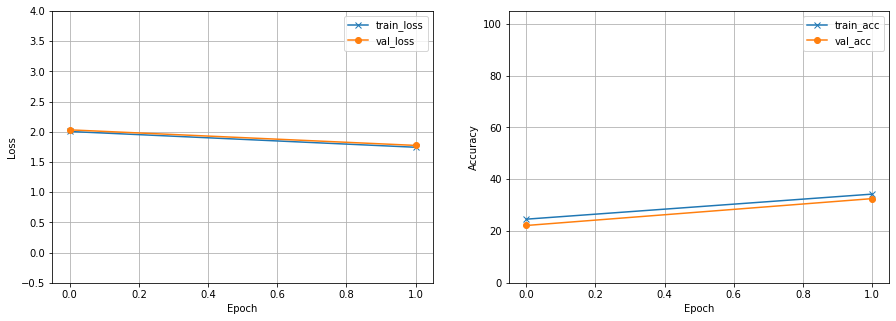

In [10]:
args = {
    'lr': 1e-3,
    'epoch': 2,
    'channel1': 16,
    'channel2': 16,
    'mid_dims': [16, 16],
    'act_name': 'relu',
    'device': 'cuda'
}
trained_model = hw_utils.spawn_train_show(
    args, train_loader, val_loader, print_model=True, print_loss=True)

## Experiment: number of epochs `[2 marks]`

Use the following configuration as default (you may use either `cpu` or `cuda`):
~~~
args = {
    'lr': 1e-3,
    'epoch': 10,
    'channel1': 128,
    'channel2': 256,
    'mid_dims': [512, 512],
    'act_name': 'relu',
    'device': 'cuda'
}
~~~
and experiment different `args['epoch']`. Report one configuration that underfit the network, and one configuration that overfits the network. Make sure you provide the `args` that you used, and the plots generated by that `args`. You can avoid printing the loss and models by setting `print_model=False`, `print_loss=False` in `spawn_train_show`.


The highest validation accuracy is 42.62 percent


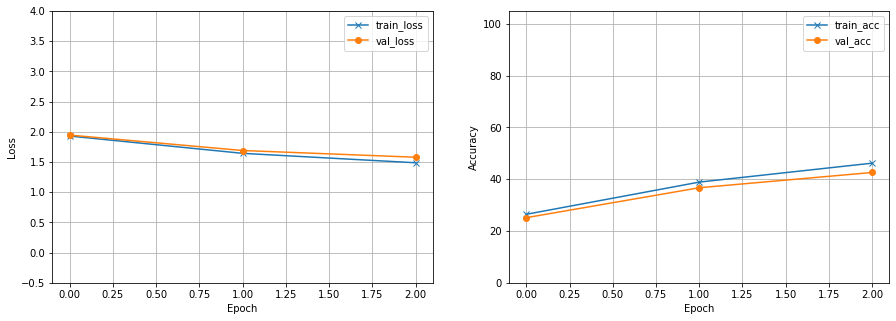

In [27]:
args = {
    # TODO
    'lr': 1e-3,
    'epoch': 3,
    'channel1': 128,
    'channel2': 256,
    'mid_dims': [512, 512],
    'act_name': 'relu',
    'device': 'cuda'
}
trained_model = hw_utils.spawn_train_show(args, train_loader, val_loader, print_model=False, print_loss=False)

**2 Epochs leads to underfitting,** since we see from 2 epochs to 3 epochs, validation loss becomes less and validation accuracy goes up.


The highest validation accuracy is 49.44 percent


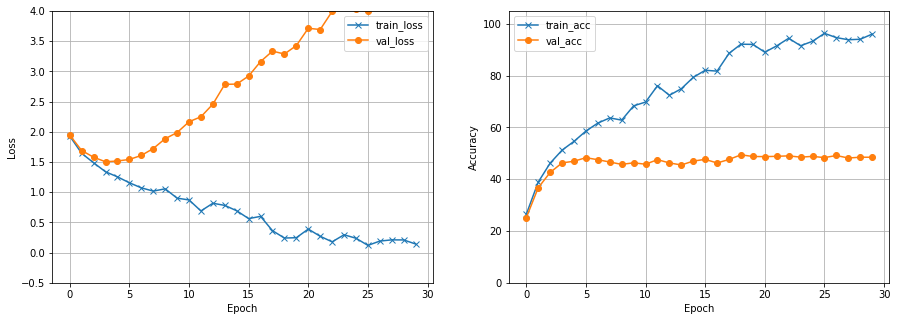

In [12]:
args = {
    # TODO
    'lr': 1e-3,
    'epoch': 30,
    'channel1': 128,
    'channel2': 256,
    'mid_dims': [512, 512],
    'act_name': 'relu',
    'device': 'cuda'
}
trained_model = hw_utils.spawn_train_show(args, train_loader, val_loader, print_model=False, print_loss=False)

**13 epochs is overfitting,** because validation loss has already started going up after 4 epochs.

## Experiment: Channel Sizes `[2 marks]`
Use the following configuration as default (you may use either `cpu` or `cuda`):
~~~
args = {
    'lr': 1e-3,
    'epoch': 20,
    'channel1': 16,
    'channel2': 16,
    'mid_dims': [256, 256],
    'act_name': 'relu',
    'device': 'cuda'
}
~~~
and experiment different combinations of `args['channel1']` and `args['channel2']`. Report one configuration that underfit the network, and one configuration that overfits the network. Make sure you provide the `args` that you used, and the plots generated by that `args`. You can avoid printing the loss and models by setting `print_model=False`, `print_loss=False` in `spawn_train_show`.


The highest validation accuracy is 38.14 percent


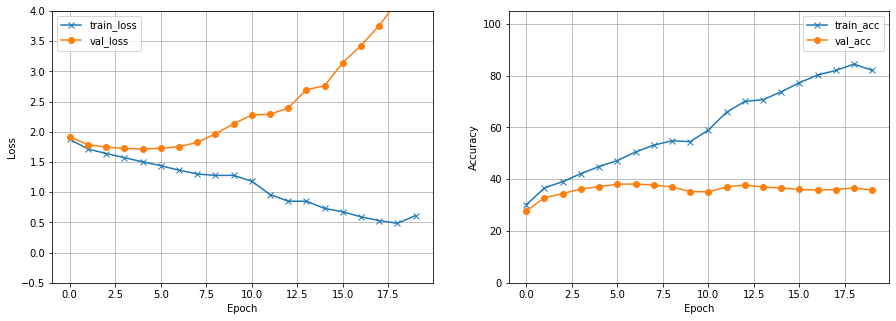

In [25]:
args = {
    # TODO
    'lr': 1e-3,
    'epoch': 20,
    'channel1': 2,
    'channel2': 2,
    'mid_dims': [256, 256],
    'act_name': 'relu',
    'device': 'cuda'
}
trained_model = hw_utils.spawn_train_show(args, train_loader, val_loader, print_model=False, print_loss=False)

**`channel1=2`, `channel2=2` is a combination that underfits.** We know this since the default configuration gives us 47% highest validation accuracy, and with this configuration we have a simpler model, but the highest accuracy drops to 38%.


The highest validation accuracy is 45.10 percent


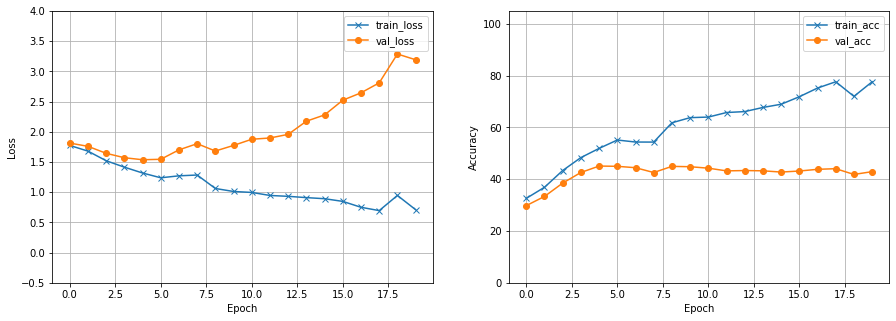

In [23]:
args = {
    # TODO
    'lr': 1e-3,
    'epoch': 20,
    'channel1': 2048,
    'channel2': 2048,
    'mid_dims': [256, 256],
    'act_name': 'relu',
    'device': 'cuda'
}
trained_model = hw_utils.spawn_train_show(args, train_loader, val_loader, print_model=False, print_loss=False)

**`channel1=2048`, `channel2=2048` is a combination that overfits.** We know this since with our baseline configuration of `channel1=16`, `channel2=16`, we can achieve 47% as highest validation accuracy, but with this configuration we have a more complex model, but can get only 45% highest validation accuracy.

## Experiment: Linear Hidden Layer Width `[2 marks]`
Use the following configuration as default (you may use either `cpu` or `cuda`):
~~~
args = {
    'lr': 1e-3,
    'epoch': 20,
    'channel1': 256,
    'channel2': 256,
    'mid_dims': [D, D],
    'act_name': 'relu',
    'device': 'cuda'
}
~~~
and experiment different `args['mid_dims'] = [D, D]` with different integer `D` (note that `args['mid_dims']` is a list of integers). Report one configuration that underfit the network, and one configuration that overfits the network. Make sure you provide the `args` that you used, and the plots generated by that `args`. You can avoid printing the loss and models by setting `print_model=False`, `print_loss=False` in `spawn_train_show`.


The highest validation accuracy is 10.22 percent


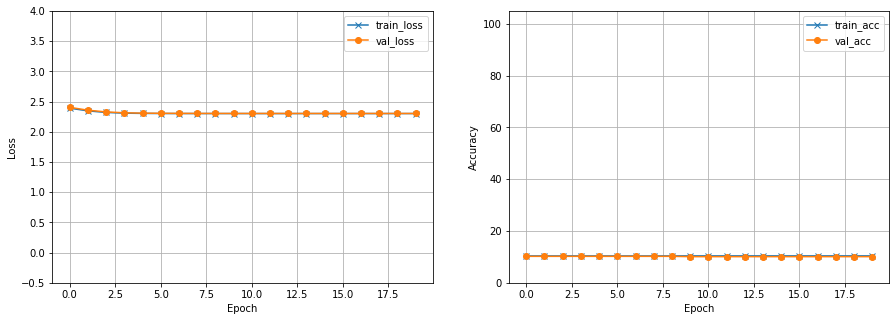

In [28]:
args = {
    # TODO
    'lr': 1e-3,
    'epoch': 20,
    'channel1': 256,
    'channel2': 256,
    'mid_dims': [1, 1],
    'act_name': 'relu',
    'device': 'cuda'
}
trained_model = hw_utils.spawn_train_show(args, train_loader, val_loader, print_model=False, print_loss=False)

**`mid_dims=[1, 1]` is underfitting.** This is because at `mid_dims=[32, 32]` we can achieve highest validation accuracy being 51%, and the 10% we got here clearly shows that our model is not complex enough to learn from the training data effectively.


The highest validation accuracy is 46.38 percent


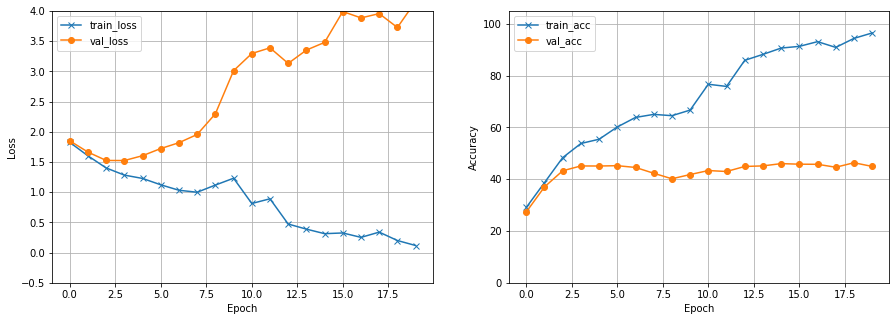

In [31]:
args = {
    # TODO
    'lr': 1e-3,
    'epoch': 20,
    'channel1': 256,
    'channel2': 256,
    'mid_dims': [2048, 2048],
    'act_name': 'relu',
    'device': 'cuda'
}
trained_model = hw_utils.spawn_train_show(args, train_loader, val_loader, print_model=False, print_loss=False)

**`mid_dims=[2048, 2048]` is overfitting.** This is because at `mid_dims=[32, 32]` we can achieve highest validation accuracy being 51%, and the 46% we got here clearly shows that increased model complexity has lead to worse performance due to overfitting.

## Experiment: Linear Layer Depth `[2 marks]`

Use the following configuration as default (you may use either `cpu` or `cuda`):
~~~
args = {
    'lr': 1e-3,
    'epoch': 20,
    'channel1': 256,
    'channel2': 256,
    'mid_dims': [256]*K,
    'act_name': 'relu',
    'device': 'cuda'
}
~~~
and experiment different `args['mid_dims'] = [256]*K` with different integer `K` (note that `args['mid_dims']` is a list of integers). Report one configuration that underfit the network, and one configuration that overfits the network. Make sure you provide the `args` that you used, and the plots generated by that `args`. You can avoid printing the loss and models by setting `print_model=False`, `print_loss=False` in `spawn_train_show`.


The highest validation accuracy is 49.94 percent


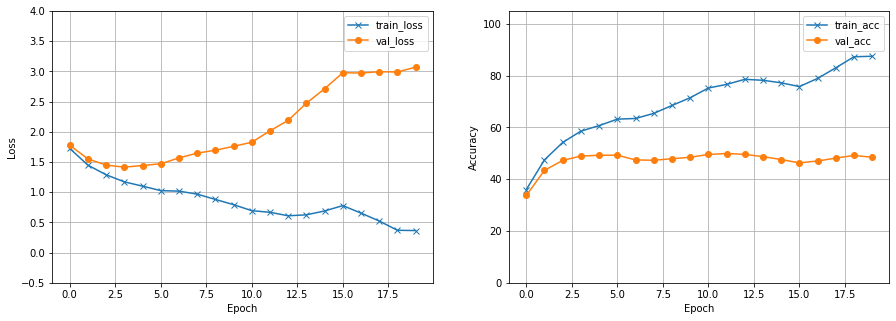

In [47]:
args = {
    # TODO
    'lr': 1e-3,
    'epoch': 20,
    'channel1': 256,
    'channel2': 256,
    'mid_dims': [256]*0,
    'act_name': 'relu',
    'device': 'cuda'
}
trained_model = hw_utils.spawn_train_show(args, train_loader, val_loader, print_model=False, print_loss=False)

**Having $K=0$ leads to underfitting.** For $K=1$, we can achieve highest validation accuracy at 50.76%. For $K=0$ though, we have no hidden layers, and the highest validation accuracy is 49.94%. So the decreased model complexity has lead to accuracy to drop.


The highest validation accuracy is 41.54 percent


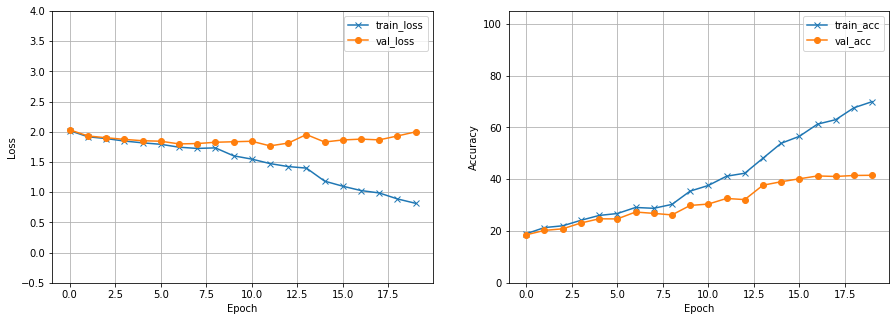

In [48]:
args = {
    # TODO
    'lr': 1e-3,
    'epoch': 20,
    'channel1': 256,
    'channel2': 256,
    'mid_dims': [256]*8,
    'act_name': 'relu',
    'device': 'cuda'
}
trained_model = hw_utils.spawn_train_show(args, train_loader, val_loader, print_model=False, print_loss=False)

**Having $K=8$ leads to overfitting.** For $K=1$, we can achieve highest validation accuracy at 50.76%. For $K=8$ though, the highest validation accuracy is only 41.54%. Clearly the increased model complexity has lead to accuracy to drop.

## Experiment: Activations `[2 marks]`

Use the following configuration as default (you may use either `cpu` or `cuda`):
~~~
args = {
    'lr': 1e-3,
    'epoch': 20,
    'channel1': 128,
    'channel2': 256,
    'mid_dims': [512, 512],
    'act_name': 'relu',
    'device': 'cuda'
}
~~~
and experiment on `args['act_name']` with the values `'relu', 'identity', 'tanh', 'sigmoid'`. Report one configuration that underfit the network, and one configuration that overfits the network. Make sure you provide the `args` that you used, and the plots generated by that `args`. You can avoid printing the loss and models by setting `print_model=False`, `print_loss=False` in `spawn_train_show`.


The highest validation accuracy is 10.10 percent


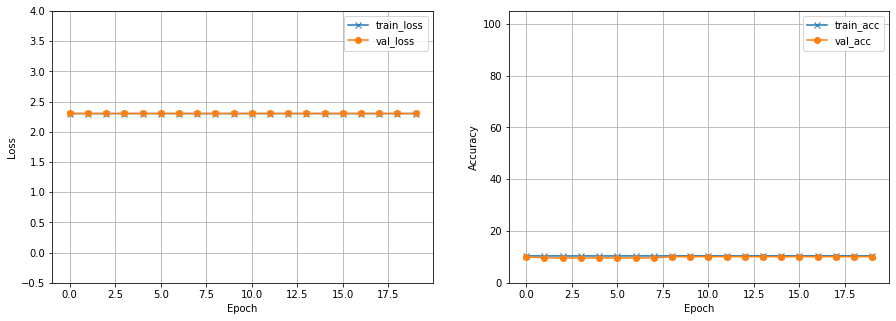

In [44]:
args = {
    # TODO
    'lr': 1e-3,
    'epoch': 20,
    'channel1': 128,
    'channel2': 256,
    'mid_dims': [512, 512],
    'act_name': 'sigmoid',
    'device': 'cuda'
}
trained_model = hw_utils.spawn_train_show(args, train_loader, val_loader, print_model=False, print_loss=False)

**Using `sigmoid` leads to underfitting.** We see training loss stays high over epochs and both validation and training accuracies are low. So we know the model is not learning well from the training set.


The highest validation accuracy is 44.84 percent


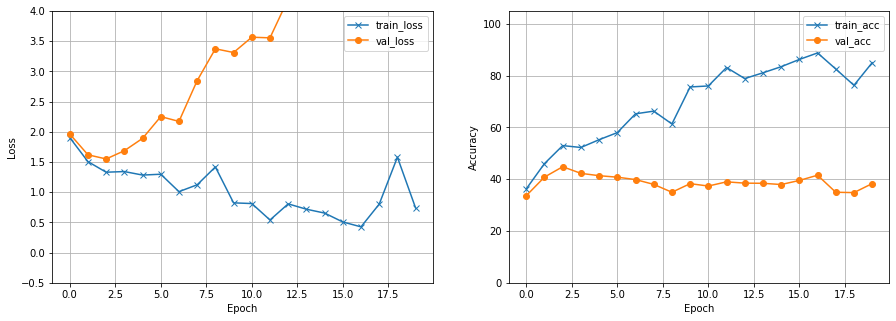

In [45]:
args = {
    # TODO
    'lr': 1e-3,
    'epoch': 20,
    'channel1': 128,
    'channel2': 256,
    'mid_dims': [512, 512],
    'act_name': 'identity',
    'device': 'cuda'
}
trained_model = hw_utils.spawn_train_show(args, train_loader, val_loader, print_model=False, print_loss=False)

**Using `identity` leads to overfitting.** We see although training loss goes down over epochs and training accuracy goes up to a good number, the discrepency between training and validation accuracy is hugh. In comparison, with `relu` we can get highest validation accuracy being 49%. So here we see overfitting.

## Creating the best model `[2 marks]`

After learning the effects of various hyper-parameters, it is time to create your final model. Experiment with different configurations in `args` and report your best hyperparameters, the training, validation accuracies. Provide the worst, and best configurations in terms of validation accuracies below:


The highest validation accuracy is 10.10 percent


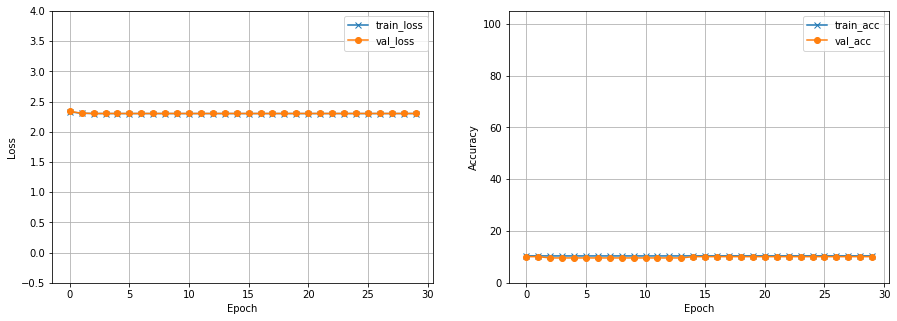

In [52]:
# Worst
args = {
    # TODO
    'lr': 1e-3,
    'epoch': 30,
    'channel1': 2,
    'channel2': 2,
    'mid_dims': [256]*8,
    'act_name': 'sigmoid',
    'device': 'cuda'
}
trained_model = hw_utils.spawn_train_show(args, train_loader, val_loader, print_model=False, print_loss=False)


The highest training accuracy is 62.24 percent
The highest validation accuracy is 50.40 percent
The final training accuracy is 62.24 percent
The final validation accuracy is 50.40 percent


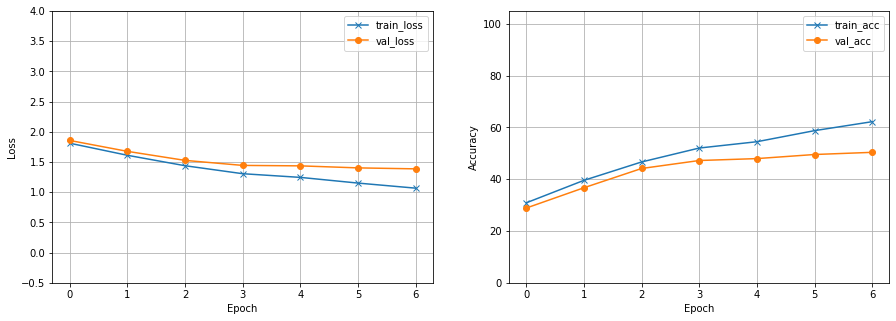

In [18]:
# Best
args = {
    # TODO
    'lr': 1e-3,
    'epoch': 7,
    'channel1': 256,
    'channel2': 256,
    'mid_dims': [32],
    'act_name': 'relu',
    'device': 'cuda'
}
trained_model = hw_utils.spawn_train_show(args, train_loader, val_loader, print_model=False, print_loss=False)

The best set of hyperparameters is:
* learning rate = `1e-3`
* 7 epochs
* Channel size = 2
* one hidden layer with width=32
* ReLU for activation

Training accuracy is 62.24% and validation accuracy is 50.40%.

In machine learning, we often split the dataset into training, validation and test set. Your "best hyper-parameters" above should be chosen based on the model performance on the validation set. After choosing the best hyper-parameters, report your results on the test set. 

In [19]:
_, test_acc = hw_utils.test(args, trained_model, test_loader)
print('The test accuracy is %.2f percent' % (test_acc))

The test accuracy is 50.30 percent


# Playing with SOTA `[4 marks]`

[Mask R-CNN](https://arxiv.org/abs/1703.06870) is one of the state-of-the-art in the image segmentation task. Image segmentation is a more general version of an object detection task. Instead of labelling the class of a bouding box, a model needs to assign a label to each pixel. You are going to experiment Mask R-CNN with your own choice of images. 

Lets import the model from the PyTorch model zoo:

In [5]:
import hw_utils
import torchvision
device = 'cuda'
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True).to(device)
model.eval()

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

The following example shows you how to apply Mask R-CNN on your choice of images. The parameter `im_path` should point to an image path in your directory; `device` can be set above to either `cuda` or `cpu`; `topk` shows the topk most confident objects detected by the network.

The demo image is taken [here](https://www.ubyssey.ca/blog/an-interview-with-the-birb/).

Visualizing birb.jpg
Resized image size: 600, 401


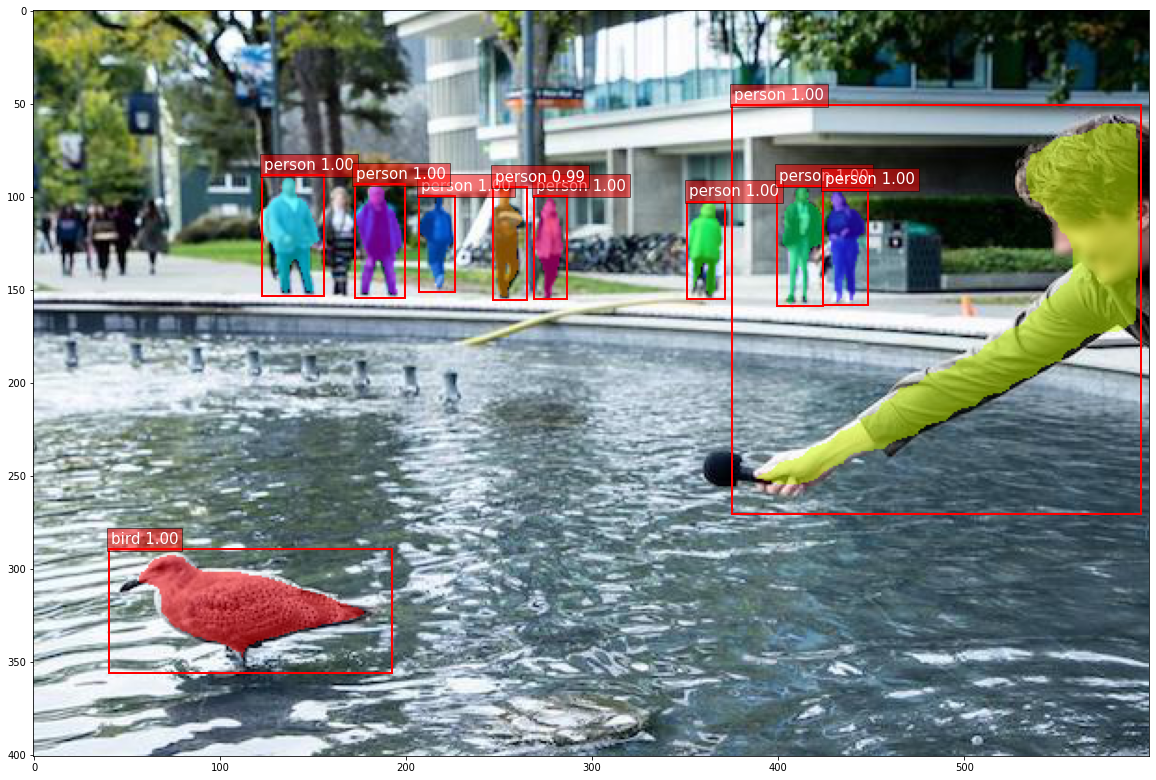

In [6]:
hw_utils.apply_mask_rcnn(im_path='birb.jpg', model=model, device=device, topk=10)

**Experiment with images of your choice and pick one image that this network would work and two images that this network will fail. Give two sentences to summarize when the model would work and when won't.**

Positive Example: this network would work on this image

Visualizing warplanes.jpg
Resized image size: 600, 443


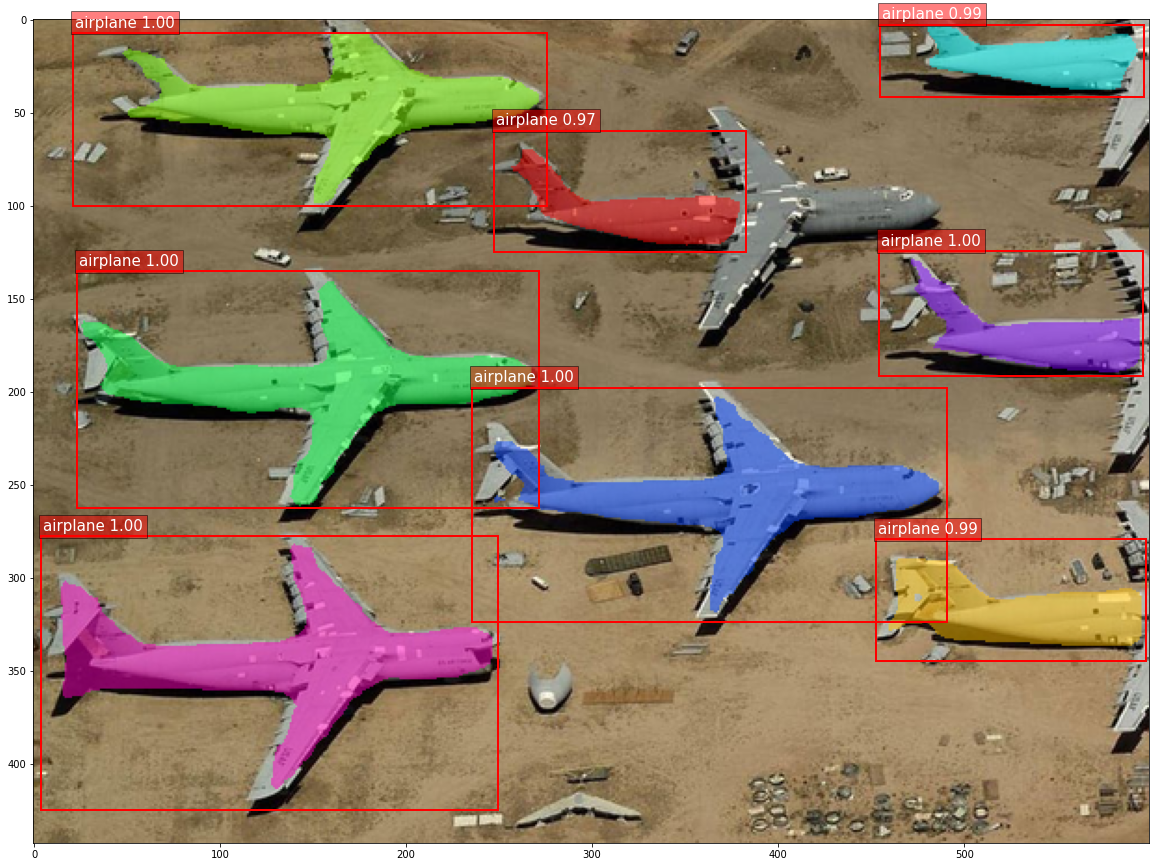

In [21]:
# image from https://www.independent.co.uk/news/world/americas/world-s-largest-plane-graveyard-us-military-fighters-desert-can-now-be-explored-online-10077079.html

hw_utils.apply_mask_rcnn(im_path='warplanes.jpg', model=model, device=device, topk=8)

Negative Examples: this network would fail on two images

Visualizing gecko.jpg
Resized image size: 600, 258


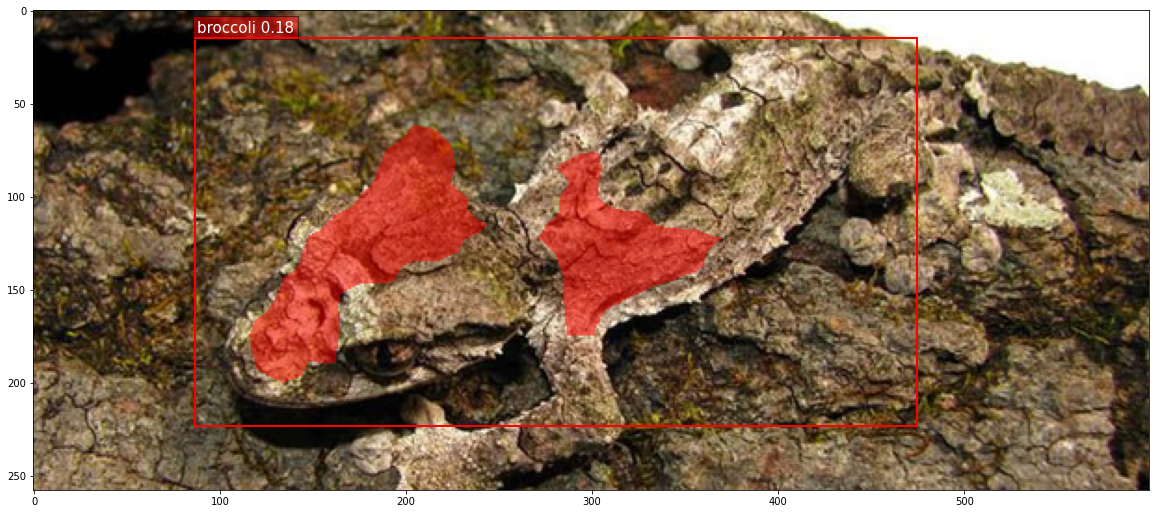

In [19]:
# image from https://www.pinterest.ca/pin/523613894159897036/

hw_utils.apply_mask_rcnn(im_path='gecko.jpg', model=model, device=device, topk=1)

Visualizing battleship.jpg
Resized image size: 600, 400


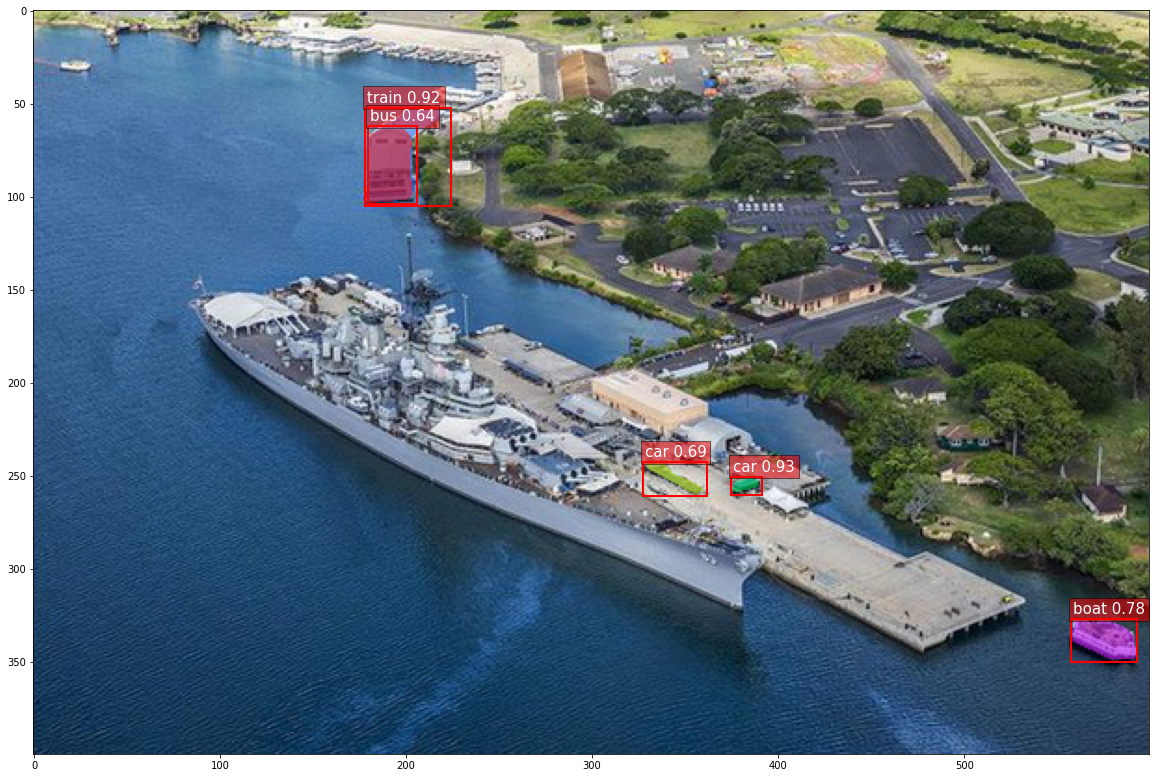

In [26]:
# image from https://www.viator.com/en-CA/tours/Oahu/Pearl-Harbor-USS-Arizona-and-Circle-Island-Day-Trip/d672-23604B

hw_utils.apply_mask_rcnn(im_path='battleship.jpg', model=model, device=device, topk=5)

When it will work?
- an object stands out from the rest of an image due to it having a clearly distinguishble boundary and significant colour contrast with background
When it will fail?
- an object does not stand out from the rest of an image, due to its boundary not clear or sharing similar colours with its background

# Submission Instructions

- Include all plots and answers on this Jupyter notebook.
- Download the Jupyter notebook with the created plots and answers.
- Submit your notebook using the naming convention `firstname_lastname_student_id.ipynb` on Canvas.

© 2020 Zicong Fan and Leonid Sigal All Rights Reserved